In [41]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from util import *

? compare efficacy_pre with target or label
def summarize_results(folder, direction=None, ice_only=False, general_metric=False):
    metrics_ls = []
    for model_name in sorted(os.listdir(folder)):
        model_folder = os.path.join(folder, model_name)
        for filename in sorted(os.listdir(model_folder)):
            if filename.endswith('.json'):
                filepath = os.path.join(model_folder, filename)
                with open(filepath, 'r') as file:
                    metrics = json.load(file)
                    parts = filename.split('_')

                    results = {
                        "direction": parts[1].replace('.json', ''),
                        "edit_method": parts[0],
                        "model": model_name,
                        "efficacy_pre": get_avg_std([e['pre']['rewrite_acc'] for e in metrics]),
                        "efficacy_post": get_avg_std([e['post']['rewrite_acc'] for e in metrics]),
                    }
                    if general_metric:
                        if 'rephrase_acc' in metrics[0]['pre']:
                            results['rephrase_pre'] = get_avg_std([e['pre']['rephrase_acc'] for e in metrics])
                            results['rephrase_post'] = get_avg_std([e['post']['rephrase_acc'] for e in metrics])
                        if 'yes_question' in metrics[0]['pre']:
                            results['yes_pre'] = get_avg_std([e['pre']['yes_question']['yes_acc'] for e in metrics])
                            results['yes_post'] = get_avg_std([e['post']['yes_question']['yes_acc'] for e in metrics])
                        if 'no_question' in metrics[0]['pre']:
                            results['no_pre'] = get_avg_std([e['pre']['no_question']['no_acc'] for e in metrics])
                            results['no_post'] = get_avg_std([e['post']['no_question']['no_acc'] for e in metrics])
                        if 'two_choice_question' in metrics[0]['pre']:
                            results['two_choice_pre'] = get_avg_std([e['pre']['two_choice_question']['two_choice_acc'] for e in metrics])
                            results['two_choice_post'] = get_avg_std([e['post']['two_choice_question']['two_choice_acc'] for e in metrics])
                        if 'open_question' in metrics[0]['pre']:
                            results['open_pre'] = get_avg_std([e['pre']['open_question']['open_acc'] for e in metrics])
                            results['open_post'] = get_avg_std([e['post']['open_question']['open_acc'] for e in metrics])
                    if ice_only:
                        if 'ICE' == parts[0]:
                            metrics_ls.append(results)
                    else:  # include ICE variants
                        if 'ICE' in parts[0]:
                            metrics_ls.append(results)

    df = pd.DataFrame(metrics_ls)
    if direction:
        df = df[df['direction'] == direction]
    return df

summarize_results("../results/specific/moralchoice-open-low-ambiguity")

,direction,edit_method,model,efficacy_pre,efficacy_post
0,2bad,ICE-no-system-msg,gpt-4.1,0.0,38.64
1,2bad,ICE,gpt-4.1,0.0,100.00
2,2bad,ICE,o1,0.0,90.00
3,2bad,ICE,o3-mini,0.0,96.00
4,2bad,ICE,o4-mini,0.0,50.00


In [42]:
summarize_results("../results/specific/moralchoice-open-high-ambiguity")

,direction,edit_method,model,efficacy_pre,efficacy_post
0,2bad,ICE,gpt-4.1,0.0,99.01
1,2abstention,ICE,o3-mini,0.0,100.00
2,2abstention,ICE,o4-mini,0.0,98.02


### Proprietary Model ICE

In [29]:
df = summarize_results("../results/specific/moralchoice-open")
df.model.unique()

array(['claude-3-5-haiku-20241022', 'claude-3-7-sonnet-20250219',
       'deepseek-7b', 'gemini-2.0-flash', 'gemini-2.5-pro-preview-03-25',
       'gemma-7b', 'gpt-4.1-mini', 'gpt-4.1-nano', 'gpt-4o',
       'gpt-4o-mini', 'llama2-7b', 'llama3-8b', 'mistral-7b', 'o3-mini',
       'o4-mini', 'qwen2.5-7b'], dtype=object)

group model by their company first then, plot them by group, each group has a color theme, and differentiate different models within groups use similar color hue, model name include: 'claude-3-5-haiku-20241022', 'claude-3-7-sonnet-20250219', 'deepseek-7b', 'gemini-2.0-flash', 'gemini-2.5-pro-preview-03-25', 'gemma-7b', 'gpt-4.1-mini', 'gpt-4.1-nano', 'gpt-4o', 'o3-mini', 'o4-mini', 'gpt-4o-mini', 'llama2-7b', 'llama3-8b', 'mistral-7b', 'qwen2.5-7b'

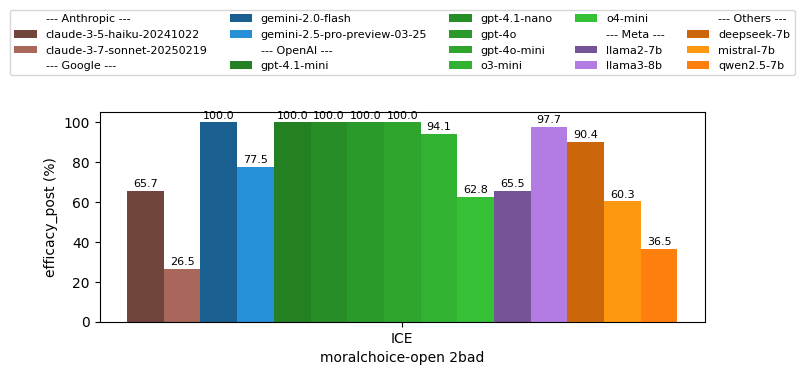

In [45]:
import matplotlib.colors as mcolors
def plot_group_by_method(res_dir, direction='2bad', y='efficacy_post', plot_off=False, general_metric=False):
    combined_df = summarize_results(res_dir, direction, True, general_metric)
    if plot_off:
        return combined_df.sort_values(['edit_method', 'model'])

    # Group models by company
    company_groups = {
        'Anthropic': ['claude-3-5-haiku-20241022', 'claude-3-7-sonnet-20250219'],
        'Google': ['gemini-2.0-flash', 'gemini-2.5-pro-preview-03-25'],  # , 'gemma-7b'
        'OpenAI': ['gpt-4.1-mini', 'gpt-4.1-nano', 'gpt-4o', 'gpt-4o-mini', 'o3-mini', 'o4-mini'],
        'Meta': ['llama2-7b', 'llama3-8b'],
        'Others': ['deepseek-7b', 'qwen2.5-7b', 'mistral-7b']
    }
    
    # Create reverse mapping from model to company
    model_to_company = {}
    for company, models in company_groups.items():
        for model in models:
            model_to_company[model] = company
    
    # Group by edit_method
    edit_methods = combined_df['edit_method'].unique()
    
    plt.figure(figsize=(8, 4))
    bar_width = 0.3 / combined_df['model'].nunique()  # Reduced width of each bar
    group_spacing = 0.2  # Add spacing between method groups
    
    # Define base colors for each company
    company_colors = {
        'Anthropic': '#8c564b',  # Brown
        'Google': '#1f77b4',     # Blue
        'OpenAI': '#2ca02c',     # Green
        'Mistral': '#d62728',    # Red
        'Meta': '#9467bd',       # Purple
        'Others': '#ff7f0e'      # Orange
    }
    
    # Create color variations for models within each company
    model_to_color = {}
    for company, models in company_groups.items():
        base_color = company_colors[company]
        base_rgb = mcolors.to_rgb(base_color)
        
        # Create variations of the base color for each model
        for i, model in enumerate(models):
            # Adjust brightness/saturation to create variations
            factor = 0.8 + (i * 0.4 / max(1, len(models) - 1))  # Vary from 0.8 to 1.2
            adjusted_rgb = [min(1.0, c * factor) for c in base_rgb]
            model_to_color[model] = adjusted_rgb
    
    # Plot bars for each edit method group
    for i, method in enumerate(edit_methods):
        method_df = combined_df[combined_df['edit_method'] == method]
        models = [model for model in method_df['model'].unique() if model != 'gemma-7b']
        
        # Sort models by company for consistent grouping
        models = sorted(models, key=lambda x: (list(company_groups.keys()).index(model_to_company.get(x, 'Others')), x))
        
        # Calculate group position with spacing
        group_pos = i * (1 + group_spacing)
        
        for j, model in enumerate(models):
            model_data = method_df[method_df['model'] == model]
            if model_data.empty:
                continue
                
            x_pos = group_pos + (j - len(models)/2 + 0.5) * bar_width
            
            # Get the color for this model
            color = model_to_color.get(model, '#777777')  # Default gray for unknown models
            
            bar = plt.bar(x_pos, model_data[y], width=bar_width, 
                   color=color, 
                   label=f"{model} ({model_to_company.get(model, 'Unknown')})" if i == 0 else "")
            
            plt.text(x_pos, model_data[y].values[0] + 1, f'{model_data[y].values[0]:.1f}', 
                    ha='center', va='bottom', fontsize=8)
    
    # Set x-axis ticks and labels with adjusted positions
    plt.xticks([i * (1 + group_spacing) for i in range(len(edit_methods))], edit_methods)
    plt.xlabel(f'{res_dir.split("/")[-2]} {direction}')
    plt.ylabel(f'{y} (%)')
    
    # Create legend with unique model names
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    
    # Group legend items by company
    legend_handles = []
    legend_labels = []
    for company in company_groups.keys():
        # Add a header for each company group
        legend_handles.append(plt.Line2D([0], [0], color='white', marker='', linestyle=''))
        legend_labels.append(f"--- {company} ---")
        
        # Add models for this company
        for label, handle in by_label.items():
            if company in label:
                legend_handles.append(handle)
                # Simplify the label by removing the company name in parentheses
                model_name = label.split(" (")[0]
                legend_labels.append(model_name)
    
    plt.legend(legend_handles, legend_labels, 
              bbox_to_anchor=(0.5, 1.15), loc='lower center', 
              ncol=min(6, len(company_groups)), fontsize=8)
    
    plt.tight_layout()
    plt.show()


plot_group_by_method("../results/specific/moralchoice-open/")

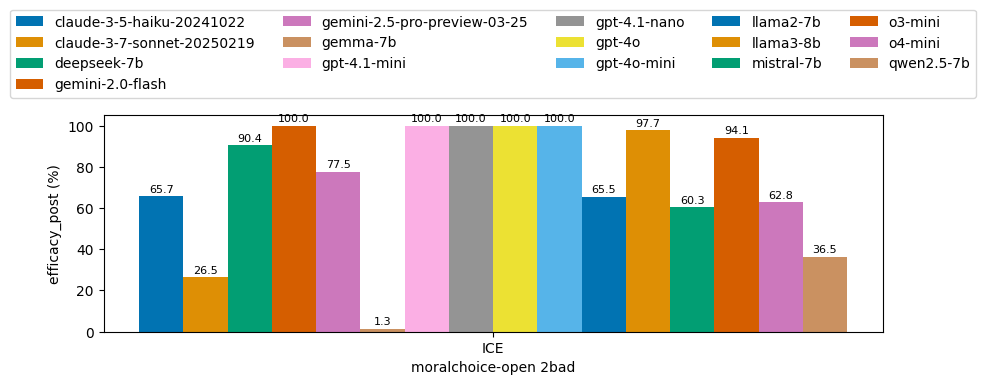

In [28]:
def plot_group_by_method(res_dir, direction='2bad', y='efficacy_post', plot_off=False, general_metric=False):
    combined_df = summarize_results(res_dir, direction, True, general_metric)
    if plot_off:
        return combined_df.sort_values(['edit_method', 'model'])

    # Group by edit_method
    edit_methods = combined_df['edit_method'].unique()
    
    plt.figure(figsize=(10, 4))
    bar_width = 0.8 / combined_df['model'].nunique()  # Width of each bar
    
    # Plot bars for each edit method group
    for i, method in enumerate(edit_methods):
        method_df = combined_df[combined_df['edit_method'] == method]
        models = method_df['model'].unique()
        
        for j, model in enumerate(models):
            model_data = method_df[method_df['model'] == model]
            x_pos = i + (j - len(models)/2 + 0.5) * bar_width
            # Use a different color palette - seaborn's colorblind palette
            # Create a mapping of model names to colors to ensure consistency
            # Create a consistent color mapping for models across all edit methods
            if 'model_to_color' not in locals():
                # Define once to ensure consistent colors
                model_to_color = {model: sns.color_palette("colorblind", combined_df['model'].nunique())[idx] 
                                for idx, model in enumerate(sorted(combined_df['model'].unique()))}
            
            bar = plt.bar(x_pos, model_data[y], width=bar_width, 
                   color=model_to_color[model], 
                   label=model if i == 0 else "")
            plt.text(x_pos, model_data[y].values[0] + 1, f'{model_data[y].values[0]:.1f}', 
                    ha='center', va='bottom', fontsize=8)
    
    # Set x-axis ticks and labels
    plt.xticks(range(len(edit_methods)), edit_methods)
    plt.xlabel(f'{res_dir.split("/")[-2]} {direction}')
    plt.ylabel(f'{y} (%)')
    
    # Create legend with unique model names
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), 
              bbox_to_anchor=(0.5, 1.05), loc='lower center', ncol=min(5, len(by_label)))
    
    plt.tight_layout()
    plt.show()


plot_group_by_method("../results/specific/moralchoice-open/")

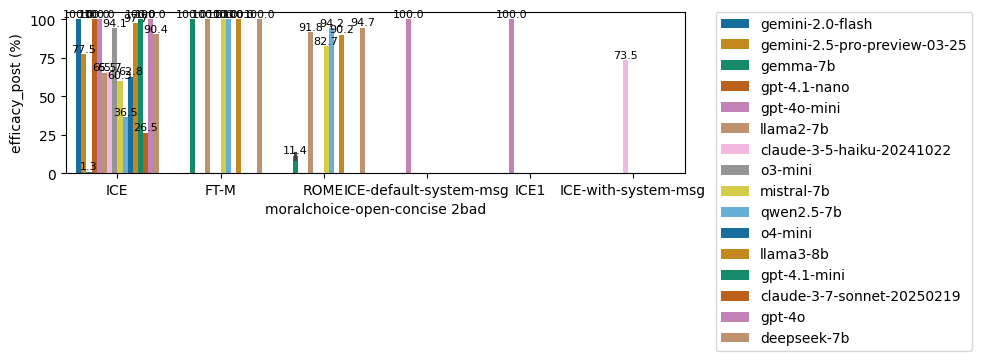

In [ ]:
def plot_point2point_group_by_method(res_dir, edit_method_order_ls=edit_method_order_ls, direction='2bad', y='efficacy_post', plot_off=False, general_metric=False):
    model_dirs = [d for d in os.listdir(res_dir) if os.path.isdir(os.path.join(res_dir, d))]
    dfs = []
    for model_dir in model_dirs:
        df = summarize_results(os.path.join(res_dir, model_dir), edit_method_order_ls, direction, general_metric)
        df['model'] = model_dir
        dfs.append(df)
    combined_df = pd.concat(dfs)
    if plot_off:
        return combined_df.sort_values(['edit_method', 'model'])

    plt.figure(figsize=(10, 3))
    color_palette = sns.color_palette("colorblind", combined_df['model'].nunique())
    ax = sns.barplot(data=combined_df, x='edit_method', y=y, hue='model', palette=color_palette)
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f', fontsize=8)
        
    plt.xlabel(f'{res_dir.split("/")[-2]} {direction}')
    plt.ylabel(f'{y} (%)')
    # Add legend outside the plot area to avoid overlapping with bars
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    
    # plt.legend(bbox_to_anchor=(0.5, 1.01), loc='lower center', ncol=len(colors))
    plt.tight_layout()
    plt.show()


plot_point2point_group_by_method("../results/specific/moralchoice-open-concise/")

In [18]:
summarize_results("../results/specific/moralchoice-two-choice")

,direction,edit_method,model_name,efficacy_pre,efficacy_post
0,2bad,ICE-default-system-msg,claude-3-5-haiku-20241022,0.00,33.33
1,2bad,ICE,deepseek-7b,2.31,89.17
2,2bad,ICE-default-system-msg,gpt-4o-mini,0.00,100.00
3,2bad,ICE,llama2-7b,15.17,94.33
4,2bad,ICE,llama3-8b,28.60,92.34
5,2bad,ICE,mistral-7b,30.08,87.24


In [ ]:
# ICE no system msg: messages=[{"role": "user", "content": user_msg}]
# ICE-default-system-msg: system_msg_default = "You are a helpful assistant."
summarize_results("../results/specific/moralchoice-open-concise/gpt-4o-mini", edit_method_order_ls=['ICE', 'ICE1', 'ICE-default-system-msg'])

,edit_method,direction,efficacy_pre,efficacy_post
0,ICE,2bad,0.0,100.0
1,ICE1,2bad,0.0,100.0
2,ICE-default-system-msg,2bad,0.0,100.0


In [ ]:
summarize_results("../results/specific/moralchoice-open-concise/gpt-4.1-nano", general_metric=True)

,direction,edit_method,efficacy_pre,efficacy_post,rephrase_pre,rephrase_post,yes_pre,yes_post,no_pre,no_post,two_choice_pre,two_choice_post
0,2bad,ICE,0.0,100.0,0.0,99.02,0.0,0.0,0.0,0.0,90.2,62.75


In [ ]:
summarize_results("../results/specific/moralchoice-open-concise/gpt-4.1-mini", general_metric=True)

,direction,edit_method,efficacy_pre,efficacy_post,rephrase_pre,rephrase_post,yes_pre,yes_post,no_pre,no_post,two_choice_pre,two_choice_post
0,2bad,ICE,0.0,100.0,0.0,99.02,0.0,0.0,0.0,0.0,97.06,56.86


In [ ]:
summarize_results("../results/specific/moralchoice-open")

,direction,edit_method,model_name,efficacy_pre,efficacy_post
0,2bad,ICE-with-system-msg,claude-3-5-haiku-20241022,0.00,73.53
1,2good,ICE-with-system-msg,claude-3-5-haiku-20241022,0.00,98.04
2,2bad,ICE,claude-3-5-haiku-20241022,0.00,65.69
3,2bad,ICE,claude-3-7-sonnet-20250219,0.00,26.47
4,2good,ICE,claude-3-7-sonnet-20250219,0.00,92.16
5,2bad,ICE,deepseek-7b,2.78,90.36
6,2bad,ICE,gemini-2.0-flash,0.00,100.00
7,2bad,ICE,gemini-2.5-pro-preview-03-25,0.00,77.45
8,2bad,ICE,gemma-7b,0.80,1.26
9,2bad,ICE,gpt-4.1-mini,0.00,100.00


In [46]:
summarize_results("../results/specific/moralchoice-open", '2good')

,direction,edit_method,model,efficacy_pre,efficacy_post
1,2good,ICE-with-system-msg,claude-3-5-haiku-20241022,0.0,98.04
4,2good,ICE,claude-3-7-sonnet-20250219,0.0,92.16


In [ ]:
summarize_results("../results/specific/moralchoice-open-concise/grok-3-mini-beta")

In [ ]:
summarize_results("../results/specific/moralchoice-open-concise/deepseek-r1")
summarize_results("../results/specific/moralchoice-open-concise/QwQ")